In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Fri Mar  5 09:30:25 PST 2021


In [ ]:
# ## TODO

# pull sdi and other missing covariates

# shift, logit transform pct pop eating vehicle
# impute missing vals for logical set of covariates (watch for covariance)
# run a linear regression by vehicle

# use outputs to predict pct pop eating vehicle / pct pop eating ind prod vehicle, shifted and logit transformed

# then finally ind prod / fortified, same method

--- 

# updates and adjustments can include gradient boosting and throwing in more/all covariates
# clipping as opposed to shifted logit


In [2]:
data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_data_estimated.csv'

# df = pd.read_csv(data_path)
df = pd.read_csv('test_add_gbd_covs.csv')

In [3]:
fao_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/inputs/FAOSTAT_food_supply_subset_2018.csv'
fao = pd.read_csv(fao_path)

In [4]:
fao.rename(columns={'Area':'location_name','Value':'wheat_supply'}, inplace=True)

In [5]:
fao = fao.loc[(fao.Item=="Wheat and products"),['location_name','wheat_supply']]

In [6]:
fao.loc[fao.location_name=="China, mainland",'location_name'] = "China"

In [7]:
df = df.drop(columns=['standard'])

In [8]:
# convert to numeric values.
# TODO: choose vals without random associations between close values
        # does it matter if the different vars are similar?
        # would it help to, say, choose veh from 10^vehicle?

In [9]:
df = df.merge(fao, on = 'location_name', how = 'left')

In [10]:
# df = df[df.vehicle=="wheat flour"].drop(columns=['sodium'])

In [11]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

In [12]:
nvehs = df.vehicle.nunique()
vcl_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

In [13]:
nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

In [14]:
df_numeric = df.copy()
df_numeric['location_name'] = df_numeric.location_name.map(loc_map)
df_numeric['vehicle'] = df_numeric.vehicle.map(vcl_map)
df_numeric['nutrient'] = df_numeric.nutrient.map(nut_map)

In [15]:
df_numeric.head()

,location_name,vehicle,nutrient,percent of population eating vehicle,percent of population eating industrially produced vehicle,percent of population eating fortified vehicle,location_id,whole_grains,sodium,wheat_supply
0,10,5,5,NaN,NaN,NaN,168,8.87061,0.981117,256.0
1,10,5,6,NaN,NaN,NaN,168,8.87061,0.981117,256.0
2,10,5,4,NaN,NaN,NaN,168,8.87061,0.981117,256.0
3,10,5,2,NaN,NaN,NaN,168,8.87061,0.981117,256.0
4,10,5,0,NaN,NaN,NaN,168,8.87061,0.981117,256.0


In [42]:
vcl_map

{'wheat flour': 5,
 'oil': 0,
 'maize flour': 1,
 'bouillon': 4,
 'salt': 3,
 'rice': 2}

In [41]:
df_numeric.groupby('vehicle').count()

,location_name,nutrient,percent_of_population_eating_vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_fortified_vehicle,location_id,whole_grains,sodium,wheat_supply
vehicle,,,,,,,,,
0,50,50,36,22,35,50,50,50,48
1,102,102,48,48,48,102,102,102,96
2,15,15,10,10,10,15,15,15,15
3,6,6,2,4,5,6,6,6,6
4,28,28,12,4,16,28,28,28,24
5,150,150,102,102,105,150,150,150,144


In [35]:
df_numeric.dropna()

,location_name,vehicle,nutrient,percent_of_population_eating_vehicle,percent_of_population_eating_industrially_produced_vehicle,percent_of_population_eating_fortified_vehicle,location_id,whole_grains,sodium,wheat_supply
12,20,5,5,62.350000,49.256500,0.155875,161,30.645066,1.869800,164.0
13,20,5,6,62.350000,49.256500,0.155875,161,30.645066,1.869800,164.0
14,20,5,4,62.350000,49.256500,0.155875,161,30.645066,1.869800,164.0
15,20,5,2,62.350000,49.256500,0.155875,161,30.645066,1.869800,164.0
...,...,...,...,...,...,...,...,...,...,...
340,14,3,4,100.000000,96.500000,0.000000,163,20.423178,2.085574,527.0
344,2,5,3,5.000000,50.000000,0.000000,15,23.833147,2.274897,69.0
348,9,5,3,97.333333,48.666667,0.000000,165,1.228010,1.427600,920.0
350,22,1,3,93.000000,25.233333,2.500000,189,16.953706,1.157473,131.0


In [40]:
df_numeric[ (df_numeric.percent_of_population_eating_fortified_vehicle.notna())].shape

(219, 10)

In [39]:
df_numeric[ (df_numeric.percent_of_population_eating_industrially_produced_vehicle.notna())].shape

(190, 10)

In [37]:
df_numeric[(df_numeric.percent_of_population_eating_vehicle.notna()) & (df_numeric.percent_of_population_eating_industrially_produced_vehicle.notna())].shape

(184, 10)

In [38]:
df_numeric.shape

(351, 10)

In [16]:
df_numeric.columns = [i.replace(" ","_") for i in df_numeric.columns]

In [17]:
estimation_vars = ['percent_of_population_eating_vehicle',
       'percent_of_population_eating_industrially_produced_vehicle',
       'percent_of_population_eating_fortified_vehicle']

In [18]:
for var in estimation_vars:
    print(f'{df_numeric[var].isnull().sum()}/{len(df_numeric)} missing for {var}')

141/351 missing for percent_of_population_eating_vehicle
161/351 missing for percent_of_population_eating_industrially_produced_vehicle
132/351 missing for percent_of_population_eating_fortified_vehicle


In [23]:
## create a version with holdouts
df_partial = df_numeric.copy()
for _ in range(len(df_numeric)*3 // 6):
    j = np.random.choice(estimation_vars)
    i = np.random.choice(df.index[df_partial[j].notnull()])
    df_partial.loc[i,j] = np.nan

In [24]:
for var in estimation_vars:
    print(f'{df_partial[var].isnull().sum()}/{len(df_partial)} missing for {var}')

189/351 missing for percent_of_population_eating_vehicle
227/351 missing for percent_of_population_eating_industrially_produced_vehicle
193/351 missing for percent_of_population_eating_fortified_vehicle


In [25]:
from statsmodels.imputation import mice

In [26]:
imp = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_partial)

In [27]:
%%time
N = 5
df_imputed = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp.update_all(n_iter=100)
    df_imputed[r] = imp.data

. . . . . CPU times: user 1min 13s, sys: 39.5 ms, total: 1min 13s
Wall time: 1min 13s


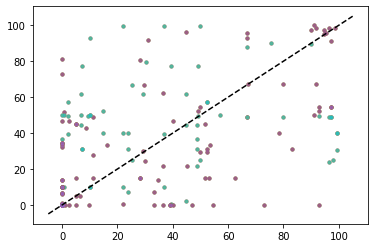

In [28]:
# let's see if we can improve with some covariates?
for col in estimation_vars:
    for df_i in df_imputed.values():
        rows = df_partial[col].isnull() & df_numeric[col].notnull()
        plt.plot(df_numeric.loc[list(rows), col], df_i.loc[list(rows), col], '.', alpha=.5)

l,r,b,t = plt.axis()
lb = min(l,b)
ub = max(r,t)
plt.plot([lb, ub], [lb, ub], 'k--')

# what happens when we use all data?

In [29]:
imp_full = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_numeric)

In [30]:
%%time
N = 5
df_imputed_full = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp_full.update_all(n_iter=100)
    df_imputed_full[r] = imp.data

. . . . . CPU times: user 1min 14s, sys: 60.5 ms, total: 1min 14s
Wall time: 1min 14s


In [31]:
# checkout performance

In [32]:
# does imp remember prev iters? should df_imputed[i+1] be 'better' than df_imputed[i]?
# did they all do the same?

In [33]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_vehicle <
                  df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle)].shape[0])

94
94
94
94
94


In [34]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle <
                  df_imputed_full[i].percent_of_population_eating_fortified_vehicle)].shape[0])

32
32
32
32
32
